# NYC Taxi & Limousine Commission

## Setup

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Analysis - Sample") \
    .getOrCreate()

# Health check
df = spark.range(5)
df.show()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/30 00:26:36 WARN Utils: Your hostname, rioly, resolves to a loopback address: 127.0.1.1; using 192.168.1.4 instead (on interface wlan0)
25/10/30 00:26:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/30 00:26:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



## Load the dataset

In [2]:
# Load sample trip data
trip_file = "../sample_data/yellow_tripdata_2025-01.parquet"
df_trips = spark.read.parquet(trip_file)
df_trips.show(5)
df_trips.printSchema()

# Load zone lookup table
zone_file = "../sample_data/taxi_zone_lookup.csv"
df_zones = spark.read.csv(zone_file, header=True, inferSchema=True)
df_zones.show(5)
df_zones.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

## First join (first shuffle)

- Join `PULocationID` from trips with LocationID from zones to get `PU_Borough`.
- Optional: later you can join dropoff as well.

In [3]:
from pyspark.sql.functions import col

df_joined = df_trips.join(
    df_zones,
    df_trips.PULocationID == df_zones.LocationID,
    "left"
).withColumnRenamed("Borough", "PU_Borough")

df_joined.select("PULocationID", "PU_Borough", "tpep_pickup_datetime").show(5)


+------------+----------+--------------------+
|PULocationID|PU_Borough|tpep_pickup_datetime|
+------------+----------+--------------------+
|         229| Manhattan| 2025-01-01 00:18:38|
|         236| Manhattan| 2025-01-01 00:32:40|
|         141| Manhattan| 2025-01-01 00:44:04|
|         244| Manhattan| 2025-01-01 00:14:27|
|         244| Manhattan| 2025-01-01 00:21:34|
+------------+----------+--------------------+
only showing top 5 rows


## First aggregation (daily per borough)

In [4]:
from pyspark.sql.functions import to_date, avg, count

df_daily = df_joined.groupBy(
    "PU_Borough",
    to_date("tpep_pickup_datetime").alias("pickup_date")
).agg(
    count("*").alias("num_trips"),
    avg("trip_distance").alias("avg_distance"),
    avg("tip_amount").alias("avg_tip")
)

df_daily.show(5)


[Stage 11:============================================>           (12 + 3) / 15]

+-------------+-----------+---------+------------------+------------------+
|   PU_Borough|pickup_date|num_trips|      avg_distance|           avg_tip|
+-------------+-----------+---------+------------------+------------------+
|     Brooklyn| 2025-01-01|     3405|  5.44858149779736|1.2226079295154189|
|Staten Island| 2025-01-02|        8| 4.211250000000001|               0.0|
|Staten Island| 2025-01-01|       15|12.292666666666667|               0.0|
|    Manhattan| 2024-12-31|       16|2.6637500000000003|           3.43875|
|        Bronx| 2025-01-04|      206| 7.652378640776698|0.5034466019417475|
+-------------+-----------+---------+------------------+------------------+
only showing top 5 rows


## Second aggregation (monthly per borough)

In [5]:
from pyspark.sql.functions import month

df_monthly = df_daily.groupBy(
    "PU_Borough",
    month("pickup_date").alias("month")
).agg(
    avg("num_trips").alias("avg_daily_trips"),
    avg("avg_distance").alias("avg_trip_distance"),
    avg("avg_tip").alias("avg_tip")
)

df_monthly.show(5)


[Stage 15:============================================>           (12 + 3) / 15]

+-------------+-----+------------------+------------------+-------------------+
|   PU_Borough|month|   avg_daily_trips| avg_trip_distance|            avg_tip|
+-------------+-----+------------------+------------------+-------------------+
|       Queens|   12|               5.0| 6.837999999999999|               6.01|
|        Bronx|    1|475.51612903225805|56.457170210973715|0.21353354278230807|
|     Brooklyn|    1|2131.2903225806454|  25.5438791921738| 0.7383545008287951|
|       Queens|    1| 9515.516129032258|13.362334585544843|  7.508430223050499|
|Staten Island|    1| 8.258064516129032| 7.766304633538504| 1.1374362519201229|
+-------------+-----+------------------+------------------+-------------------+
only showing top 5 rows


## Fancy plots

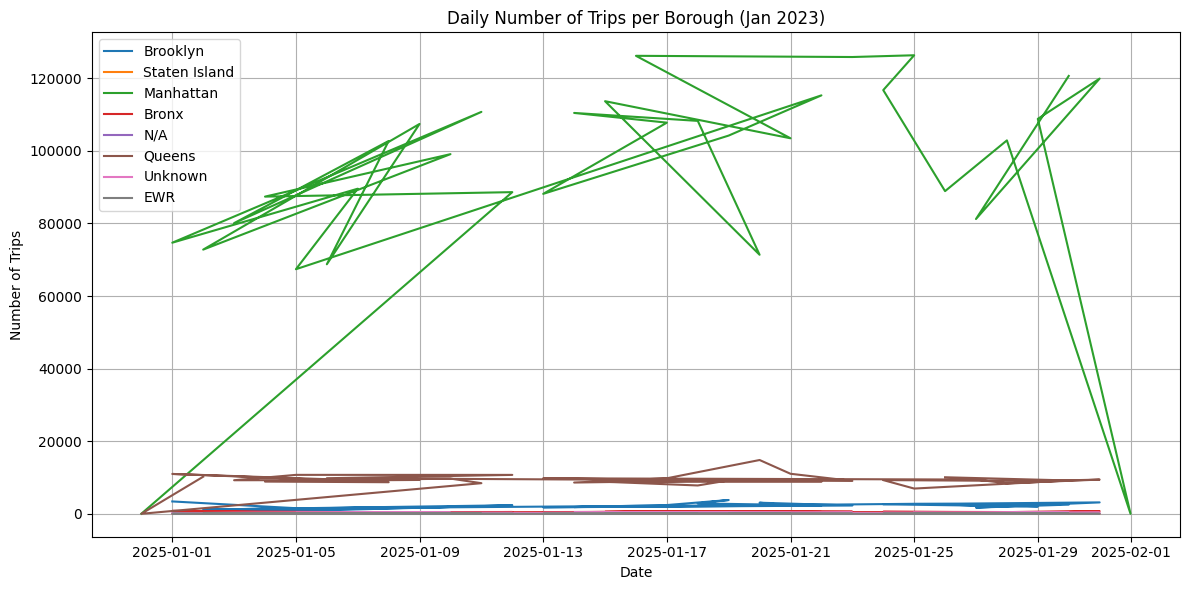

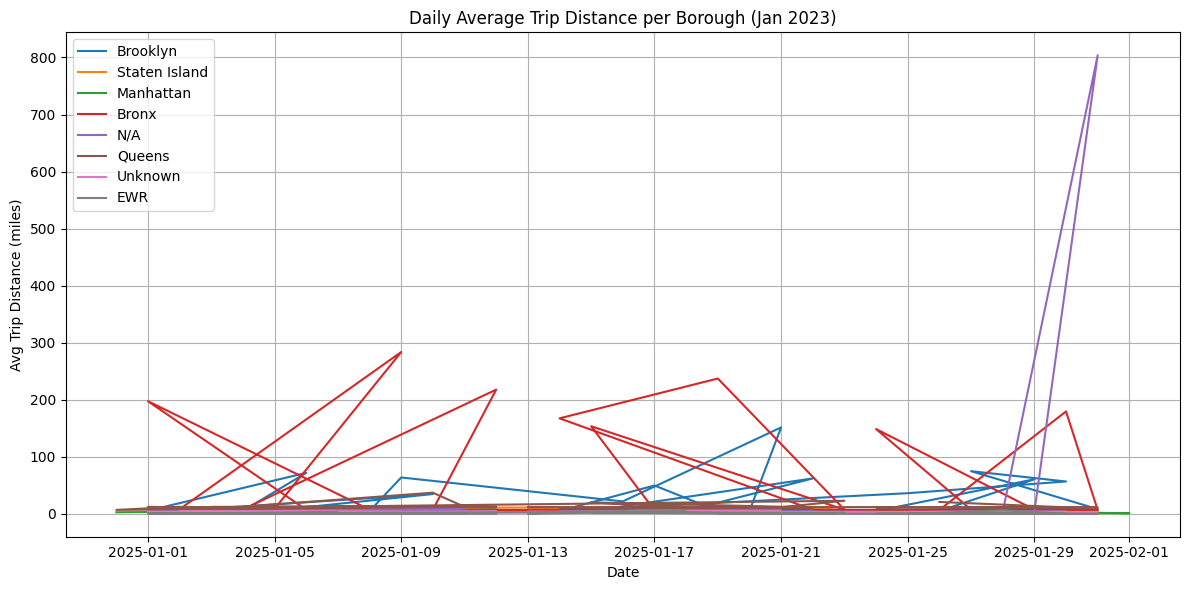

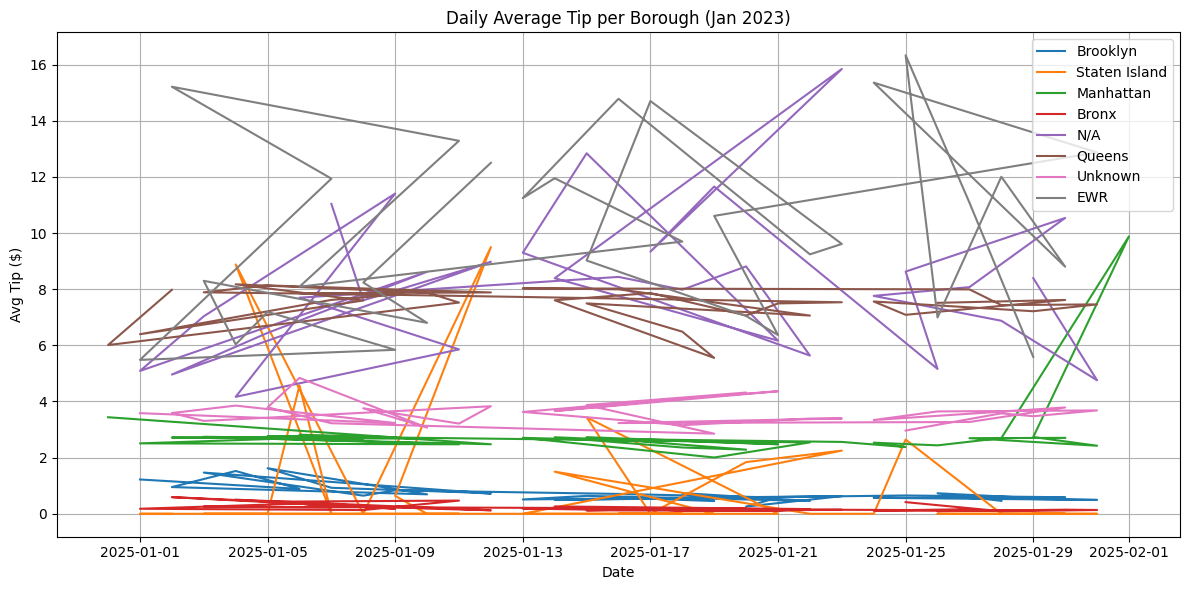

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert daily aggregation to Pandas
pdf_daily = df_daily.toPandas()
pdf_daily['pickup_date'] = pd.to_datetime(pdf_daily['pickup_date'])
pdf_daily.head()

plt.figure(figsize=(12,6))

for borough in pdf_daily['PU_Borough'].unique():
    subset = pdf_daily[pdf_daily['PU_Borough'] == borough]
    plt.plot(subset['pickup_date'], subset['num_trips'], label=borough)

plt.title("Daily Number of Trips per Borough (Jan 2023)")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))

for borough in pdf_daily['PU_Borough'].unique():
    subset = pdf_daily[pdf_daily['PU_Borough'] == borough]
    plt.plot(subset['pickup_date'], subset['avg_distance'], label=borough)

plt.title("Daily Average Trip Distance per Borough (Jan 2023)")
plt.xlabel("Date")
plt.ylabel("Avg Trip Distance (miles)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))

for borough in pdf_daily['PU_Borough'].unique():
    subset = pdf_daily[pdf_daily['PU_Borough'] == borough]
    plt.plot(subset['pickup_date'], subset['avg_tip'], label=borough)

plt.title("Daily Average Tip per Borough (Jan 2023)")
plt.xlabel("Date")
plt.ylabel("Avg Tip ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
